# Prévisions météorologiques en Australie

# Prévision des précipitations avec étape de ré-échantillonage

## Récupération des librairies

In [1]:
# récupération du package scikit-plot
!pip install scikit-plot

In [2]:
# récupération du package imblearn
!pip install --upgrade imblearn

  Using cached scikit_learn-1.1.3-cp39-cp39-win_amd64.whl (7.6 MB)
  Using cached joblib-1.2.0-py3-none-any.whl (297 kB)
  Attempting uninstall: joblib
    Found existing installation: joblib 0.11
    Uninstalling joblib-0.11:
      Successfully uninstalled joblib-0.11
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.0.2
    Uninstalling scikit-learn-1.0.2:
      Successfully uninstalled scikit-learn-1.0.2


In [3]:
# récupération des librairies
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import time, datetime
import scikitplot as skplt
import warnings
warnings.filterwarnings("ignore")

from sklearn import neighbors
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, recall_score, f1_score, precision_score
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

from imblearn.under_sampling import RandomUnderSampler, ClusterCentroids
from imblearn.over_sampling import RandomOverSampler, SMOTE

## Modèles de classification par apprentissage supervisé

### Préparation du jeu de données et paramètrage

In [4]:
# récuperation et aperçu du jeu de données après prétraitement des données, après l'étape de classification des villes 
# en fonction du climat et après sélection des variables les plus pertinentes selon la méthode SelectKBest()
df = pd.read_csv('../data/weatherAUS_preprocessed.csv', index_col=0)
df.head()

,Rainfall,Sunshine,WindGustSpeed,Humidity3pm,Pressure9am,Cloud3pm,Temp3pm,Temp_Delta_MinMax,Humidity_Delta,clim_chaud_humide,clim_méditerranéen,clim_sec,clim_tempéré_froid,RainTomorrow
0,0.6,4.94000,44.0,22.0,1007.7,7.40000,21.8,9.5,-49.0,1,0,0,0,0
1,0.0,7.63054,44.0,25.0,1010.6,4.49925,24.3,17.7,-19.0,1,0,0,0,0
2,0.0,7.96000,46.0,30.0,1007.6,2.00000,23.2,12.8,-8.0,1,0,0,0,0
3,0.0,7.63054,24.0,16.0,1017.6,4.49925,26.5,18.8,-29.0,1,0,0,0,0
4,1.0,0.90000,41.0,33.0,1010.8,8.00000,29.7,14.8,-49.0,1,0,0,0,0


In [5]:
# séparation des données en une matrice de données et en un vecteur cible
data = df.drop('RainTomorrow', axis=1)
target = df['RainTomorrow']

In [6]:
# division des données en un ensemble d'entraînement et un ensemble de test correspondant respectivement 
# à 80% et 20% de la quantité totale des données disponibles
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.2, random_state=123)

In [7]:
# distribution de la variable cible dans l'ensemble d'entraînement
print("Cardinalité des classes de la variable cible dans l'ensemble d'entraînement:", 
      dict(pd.Series(y_train).value_counts()))

Cardinalité des classes de la variable cible dans l'ensemble d'entraînement: {0: 87624, 1: 25005}


In [8]:
# distribution de la variable cible dans l'ensemble d'entraînement
y_train.value_counts(normalize=True)

0    0.777988
1    0.222012
Name: RainTomorrow, dtype: float64

In [9]:
# distribution de la variable cible dans l'ensemble de test
print("Cardinalité des classes de la variable cible dans l'ensemble de test:", 
      dict(pd.Series(y_test).value_counts()))

Cardinalité des classes de la variable cible dans l'ensemble de test: {0: 21962, 1: 6196}


In [10]:
# distribution de la variable cible dans l'ensemble de test
y_test.value_counts(normalize=True)

0    0.779956
1    0.220044
Name: RainTomorrow, dtype: float64

In [11]:
# paramètre à initialiser pour calculer les performances des algorithmes avec ré-échantillonage
# param_ru = 'rOs' # RandomOverSampler
param_ru = 'rUs' # RandomUnderSampler # considéré dans le cadre de cette étude
# param_ru = 'smo' # SMOTE
# param_ru = 'cc' # ClusterCentroids

In [12]:
# oversampling des données
if param_ru == 'rOs':
    rOs = RandomOverSampler()
    X_train, y_train = rOs.fit_resample(X_train, y_train)
elif param_ru == 'smo':
    smo = SMOTE()
    X_train, y_train = smo.fit_resample(X_train, y_train)

In [13]:
# undersampling des données
if param_ru == 'rUs':
    rUs = RandomUnderSampler()
    X_train, y_train = rUs.fit_resample(X_train, y_train)
elif param_ru == 'cc':
    cc = ClusterCentroids()
    X_train, y_train = cc.fit_resample(X_train, y_train)

In [14]:
# distribution de la variable cible ré-échantillonnée dans l'ensemble de test
print("Cardinalité des classes de la variable cible ré-échantillonnée:", dict(pd.Series(y_train).value_counts()))

Cardinalité des classes de la variable cible ré-échantillonnée: {0: 25005, 1: 25005}


In [15]:
# distribution de la variable cible ré-échantillonnée dans l'ensemble de test
y_train.value_counts(normalize=True)

0    0.5
1    0.5
Name: RainTomorrow, dtype: float64

In [16]:
# standardisation des données
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [17]:
# paramètre à initialiser pour définir la règle d'évaluation des modèles
scoring = 'accuracy' # considéré dans le cadre de cette étude
# scoring = 'f1' # considéré dans le cadre de cette étude

### Régression Logistique

In [18]:
# définition du modèle
clf_lr = LogisticRegression(class_weight={0:2, 1:1})

param_grid_lr = {'solver':['liblinear', 'lbfgs', 'newton-cg', 'sag', 'saga'], 
                 'C':np.linspace(0.1,1,10)}

gcv_lr = GridSearchCV(clf_lr, param_grid_lr, scoring=scoring, cv=3)

In [19]:
start_time = time.time()

# entraînement du modèle
gcv_lr.fit(X_train_scaled, y_train)

# prédiction du modèle
y_pred = gcv_lr.predict(X_test_scaled)

# détermination des meilleurs paramètres
print('Meilleurs paramètres:', gcv_lr.best_params_, "\n")

# évaluation de la performance
print('Accuracy Score: {}'.format(accuracy_score(y_test, y_pred)),'\n')

# underfitting / overfitting
print('Train Data Score: {}'.format(gcv_lr.score(X_train_scaled, y_train)))
print('Test Data Score: {}'.format(gcv_lr.score(X_test_scaled, y_test)))

# matrice de confusion
print('\n Matrice de confusion:')
print('\n', pd.crosstab(y_test, y_pred, rownames=['Réalités'], colnames=['Prédictions']))

# rapport de classification
print('\n', classification_report(y_test, y_pred))

# durée d'exécution
gaussian_time = (time.time() - start_time)
print("Running Time: %s" % datetime.timedelta(seconds=gaussian_time))

Meilleurs paramètres: {'C': 0.2, 'solver': 'liblinear'} 

Accuracy Score: 0.8325165139569571 

Train Data Score: 0.7522095580883823
Test Data Score: 0.8325165139569571

 Matrice de confusion:

 Prédictions      0     1
Réalités                
0            19571  2391
1             2325  3871

               precision    recall  f1-score   support

           0       0.89      0.89      0.89     21962
           1       0.62      0.62      0.62      6196

    accuracy                           0.83     28158
   macro avg       0.76      0.76      0.76     28158
weighted avg       0.83      0.83      0.83     28158

Running Time: 0:00:19.949678


- la méthode de régression logistique **ne fait pas l'objet de sur-apprentissage** (score par défaut de la méthode).
- la sensibilité (taux de vrais positifs) vaut 0.62.
- la spécificité (taux de vrais négatifs) vaut 0.89.
- le F1-score concernant la classe '0' de la variable 'RainTomorrow' est très bon (0.89).
- le F1-score concernant la classe '1' de la variable 'RainTomorrow' est faible (0.62).

La classe '1' est caractérisée par une précision faible, ce qui signifie que la classe n'est pas très bien détectée, et un rappel faible, ce qui signifie que la classe inclut également des observations d'autres classes lorsqu'elle est détectée.

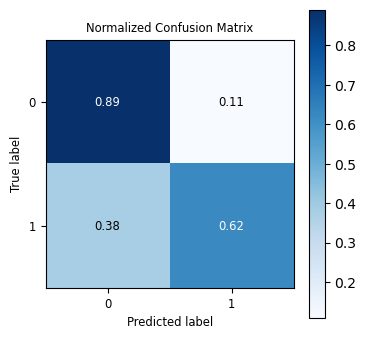

In [20]:
# affichage de la matrice de confusion normalisée
skplt.metrics.plot_confusion_matrix(y_test, y_pred, normalize=True, figsize=(4,4), 
                                    title_fontsize='small', text_fontsize='small');

In [21]:
# affichage des combinaisons possibles d'hyperparamètres et des performances moyennes du modèle associé
grid = pd.DataFrame.from_dict(gcv_lr.cv_results_).loc[:,['params','rank_test_score','mean_test_score',
                                                         'mean_fit_time','mean_score_time']]
grid.set_index('rank_test_score').sort_values(by='rank_test_score')

,params,mean_test_score,mean_fit_time,mean_score_time
rank_test_score,,,,
1,"{'C': 0.2, 'solver': 'liblinear'}",0.75225,0.057163,0.001677
2,"{'C': 0.2, 'solver': 'sag'}",0.75223,0.266557,0.002638
2,"{'C': 0.2, 'solver': 'saga'}",0.75223,0.183018,0.004339
4,"{'C': 0.1, 'solver': 'liblinear'}",0.75221,0.050210,0.003080
4,"{'C': 0.6, 'solver': 'sag'}",0.75221,0.280983,0.002171
4,"{'C': 0.6, 'solver': 'saga'}",0.75221,0.205442,0.002341
4,"{'C': 0.7000000000000001, 'solver': 'liblinear'}",0.75221,0.068260,0.002004
4,"{'C': 0.7000000000000001, 'solver': 'lbfgs'}",0.75221,0.040962,0.002169
4,"{'C': 0.7000000000000001, 'solver': 'newton-cg'}",0.75221,0.121120,0.001333


In [22]:
# méthode d'évaluation du score sur le jeu d'entraînement par cross-validation
cv_scores_train = cross_val_score(gcv_lr, X_train_scaled, y_train, cv=3, scoring=scoring)

print('Cross-validation scores (train): {}'.format(cv_scores_train))
print('Average cross-validation score (train): {}'.format(cv_scores_train.mean()))

Cross-validation scores (train): [0.74991002 0.7539892  0.75266947]
Average cross-validation score (train): 0.7521895620875824


- **Le score de la méthode de régression logistique pour le jeu d'entraînement est en moyenne de : 0.75**.

In [23]:
# méthode d'évaluation du score sur le jeu de test par cross-validation
cv_scores_test = cross_val_score(gcv_lr, X_test_scaled, y_test, cv=3, scoring=scoring)

print('Cross-validation scores (test): {}'.format(cv_scores_test))
print('Average cross-validation score (test): {}'.format(cv_scores_test.mean()))

Cross-validation scores (test): [0.83358193 0.83763051 0.83880247]
Average cross-validation score (test): 0.8366716386106968


- **Le score de la méthode de régression logistique pour le jeu de test est en moyenne de : 0.84**.

In [24]:
# probabilités pour "X_test_scaled" d'appartenir à chacune des deux classes
y_probas = gcv_lr.predict_proba(X_test_scaled)

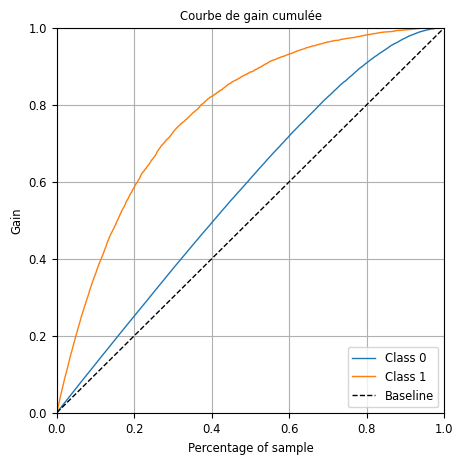

In [25]:
# affichage de la courbe de gain cumulée
ax = skplt.metrics.plot_cumulative_gain(y_test, y_probas, figsize=(5,5), title_fontsize='small', text_fontsize='small')
for l in ax.lines:
    l.set_lw(1.0)
ax.legend(loc="lower right", fontsize="small")
ax.set_title("Courbe de gain cumulée", fontsize="small");

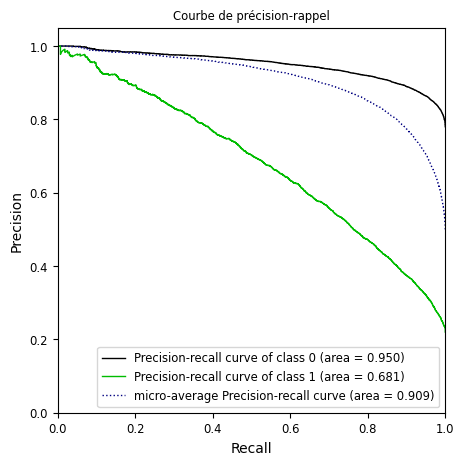

In [26]:
# affichage de la courbe de précision-rappel
ax = skplt.metrics.plot_precision_recall(y_test, y_probas, figsize=(5,5), title_fontsize='small', text_fontsize='small')
for l in ax.lines:
    l.set_lw(1.0)
ax.legend(loc="lower right", fontsize="small")
ax.set_title("Courbe de précision-rappel", fontsize="small");

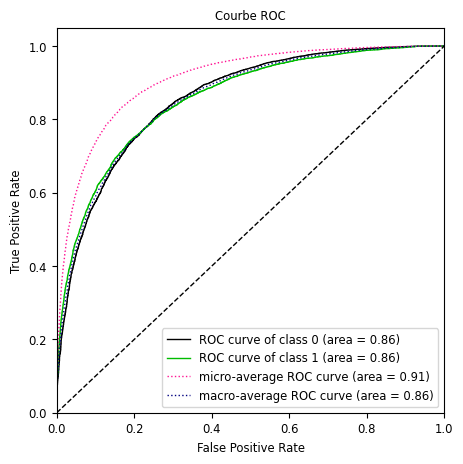

In [27]:
# affichage de la courbe ROC
ax = skplt.metrics.plot_roc(y_test, y_probas, figsize=(5,5), title_fontsize='small', text_fontsize='small')
for l in ax.lines:
    l.set_lw(1.0)
ax.legend(loc="lower right", fontsize="small")
ax.set_title("Courbe ROC", fontsize="small");

In [28]:
# sauvegarde des performances dans un fichier de sortie
pd.DataFrame([cv_scores_train.mean(), cv_scores_test.mean(),
              f1_score(y_test, y_pred), recall_score(y_test, y_pred), precision_score(y_test, y_pred)],
             index=['cv_scores_train','cv_scores_test','f1_class_1','recall_class_1','precision_class_1'], 
             columns=['lr_' + param_ru]).to_csv('../scores/lr_'+scoring+'_'+param_ru+'.csv')

### Forêts Aléatoires

In [29]:
# définition du modèle
clf_rf  = RandomForestClassifier(class_weight={0:2, 1:1})

param_grid_rf  = [{'n_estimators' : [50, 100, 150], 
                   'min_samples_leaf' : np.arange(1,6,1),
                   'max_features' : ['sqrt', 'log2']}]

gcv_rf = GridSearchCV(clf_rf, param_grid_rf, scoring=scoring)

In [30]:
start_time = time.time()

# entraînement du modèle
gcv_rf.fit(X_train_scaled, y_train)

# prédiction du modèle
y_pred = gcv_rf.predict(X_test_scaled)

# détermination des meilleurs paramètres
print('Meilleurs paramètres:', gcv_rf.best_params_,"\n")

# évaluation de la performance
print('Accuracy Score: {}'.format(accuracy_score(y_test, y_pred)),'\n')

# underfitting / overfitting
print('Train Data Score: {}'.format(gcv_rf.score(X_train_scaled, y_train)))
print('Test Data Score: {}'.format(gcv_rf.score(X_test_scaled, y_test)))

# matrice de confusion
print('\n Matrice de confusion:')
print('\n', pd.crosstab(y_test, y_pred, rownames=['Réalités'], colnames=['Prédictions']))

# rapport de classification
print('\n', classification_report(y_test, y_pred))

# durée d'exécution
gaussian_time = (time.time() - start_time)
print("Running Time: %s" % datetime.timedelta(seconds=gaussian_time))

Meilleurs paramètres: {'max_features': 'sqrt', 'min_samples_leaf': 1, 'n_estimators': 150} 

Accuracy Score: 0.7900774202713261 

Train Data Score: 1.0
Test Data Score: 0.7900774202713261

 Matrice de confusion:

 Prédictions      0     1
Réalités                
0            17317  4645
1             1266  4930

               precision    recall  f1-score   support

           0       0.93      0.79      0.85     21962
           1       0.51      0.80      0.63      6196

    accuracy                           0.79     28158
   macro avg       0.72      0.79      0.74     28158
weighted avg       0.84      0.79      0.80     28158

Running Time: 0:10:26.294704


- la méthode de forêt aléatoire **fait l'objet de sur-apprentissage** (score par défaut de la méthode).
- la sensibilité (taux de vrais positifs) vaut 0.80.
- la spécificité (taux de vrais négatifs) vaut 0.79.
- le F1-score concernant la classe '0' de la variable 'RainTomorrow' est très bon (0.93).
- le F1-score concernant la classe '1' de la variable 'RainTomorrow' est très faible (0.51).

La classe '1' est caractérisée par une précision très faible, ce qui signifie que la classe n'est quasiment pas détectée, et un rappel élevé, ce qui signifie que la classe inclut peu d'observations d'autres classes lorsqu'elle est détectée.

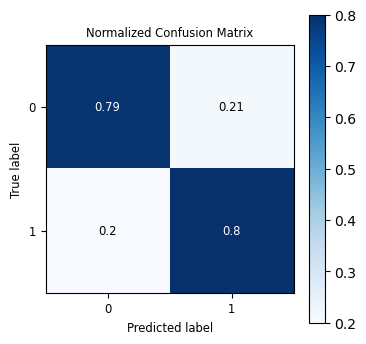

In [31]:
# affichage de la matrice de confusion normalisée
skplt.metrics.plot_confusion_matrix(y_test, y_pred, normalize=True, figsize=(4,4), 
                                    title_fontsize='small', text_fontsize='small');

In [32]:
# affichage des combinaisons possibles d'hyperparamètres et des performances moyennes du modèle associé
grid = pd.DataFrame.from_dict(gcv_rf.cv_results_).loc[:,['params','rank_test_score','mean_test_score',
                                                         'mean_fit_time','mean_score_time']]
grid.set_index('rank_test_score').sort_values(by='rank_test_score')

,params,mean_test_score,mean_fit_time,mean_score_time
rank_test_score,,,,
1,"{'max_features': 'sqrt', 'min_samples_leaf': 1...",0.786663,6.481951,0.286475
2,"{'max_features': 'sqrt', 'min_samples_leaf': 2...",0.786283,4.116270,0.178571
3,"{'max_features': 'log2', 'min_samples_leaf': 1...",0.785943,6.432752,0.279327
4,"{'max_features': 'sqrt', 'min_samples_leaf': 1...",0.785923,4.331597,0.190790
5,"{'max_features': 'sqrt', 'min_samples_leaf': 2...",0.785863,6.148520,0.278953
6,"{'max_features': 'log2', 'min_samples_leaf': 2...",0.785183,6.061164,0.270128
7,"{'max_features': 'log2', 'min_samples_leaf': 1...",0.785103,4.303755,0.189891
8,"{'max_features': 'sqrt', 'min_samples_leaf': 1...",0.783603,2.165570,0.095574
9,"{'max_features': 'log2', 'min_samples_leaf': 2...",0.783363,4.029419,0.179453


In [33]:
# méthode d'évaluation du score sur le jeu d'entraînement par cross-validation
cv_scores_train = cross_val_score(gcv_rf, X_train_scaled, y_train, cv=3, scoring=scoring)

print('Cross-validation scores (train): {}'.format(cv_scores_train))
print('Average cross-validation score (train): {}'.format(cv_scores_train.mean()))

Cross-validation scores (train): [0.7839832  0.78530294 0.78086383]
Average cross-validation score (train): 0.7833833233353329


- **Le score de la méthode des forêts aléatoires pour le jeu d'entraînement est en moyenne de : 0.78**.

In [34]:
# méthode d'évaluation du score sur le jeu de test par cross-validation
cv_scores_test = cross_val_score(gcv_rf, X_test_scaled, y_test, cv=3, scoring=scoring)

print('Cross-validation scores (test): {}'.format(cv_scores_test))
print('Average cross-validation score (test): {}'.format(cv_scores_test.mean()))

Cross-validation scores (test): [0.84892393 0.85275943 0.84913701]
Average cross-validation score (test): 0.8502734569216565


- **Le score de la méthode des forêts aléatoires pour le jeu de test est en moyenne de : 0.85**.

In [35]:
# probabilités pour "X_test_scaled" d'appartenir à chacune des deux classes
y_probas = gcv_rf.predict_proba(X_test_scaled)

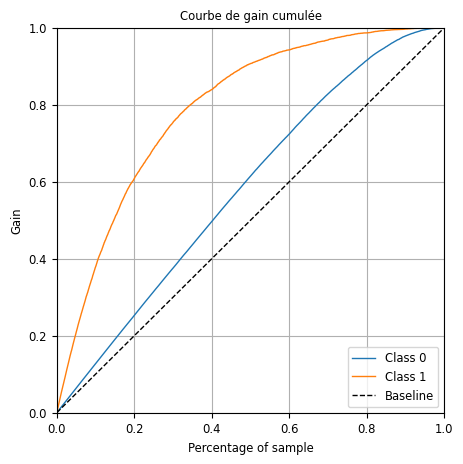

In [36]:
# affichage de la courbe de gain cumulée
ax = skplt.metrics.plot_cumulative_gain(y_test, y_probas, figsize=(5,5), title_fontsize='small', text_fontsize='small')
for l in ax.lines:
    l.set_lw(1.0)
ax.legend(loc="lower right", fontsize="small")
ax.set_title("Courbe de gain cumulée", fontsize="small");

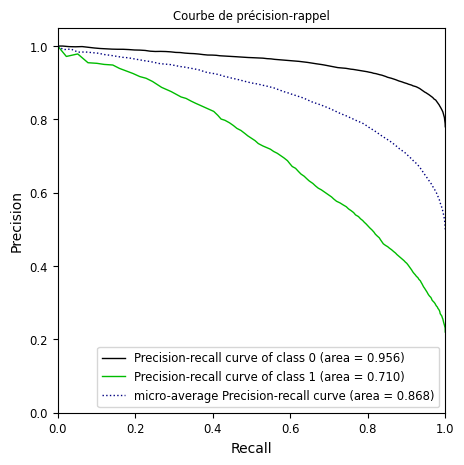

In [37]:
# affichage de la courbe de précision-rappel
ax = skplt.metrics.plot_precision_recall(y_test, y_probas, figsize=(5,5), title_fontsize='small', text_fontsize='small')
for l in ax.lines:
    l.set_lw(1.0)
ax.legend(loc="lower right", fontsize="small")
ax.set_title("Courbe de précision-rappel", fontsize="small");

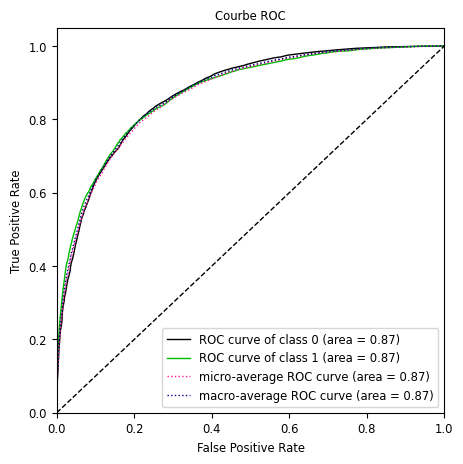

In [38]:
# affichage de la courbe ROC
ax = skplt.metrics.plot_roc(y_test, y_probas, figsize=(5,5), title_fontsize='small', text_fontsize='small')
for l in ax.lines:
    l.set_lw(1.0)
ax.legend(loc="lower right", fontsize="small")
ax.set_title("Courbe ROC", fontsize="small");

In [39]:
# sauvegarde des performances dans un fichier de sortie
pd.DataFrame([cv_scores_train.mean(), cv_scores_test.mean(), 
              f1_score(y_test, y_pred), recall_score(y_test, y_pred), precision_score(y_test, y_pred)],
             index=['cv_scores_train','cv_scores_test','f1_class_1','recall_class_1','precision_class_1'], 
             columns=['rf_' + param_ru]).to_csv('../scores/rf_'+scoring+'_'+param_ru+'.csv')

### Séparateurs à Vaste Marge (SVM)

Les séparateurs à vaste marge (SVM) visent à résoudre les problèmes de classification en trouvant de bonnes frontières de décision entre deux ensembles de points appartenant à deux catégories différentes. Une frontière de décision peut être considérée comme une ligne ou une surface séparant les données d’apprentissage en deux demi-espaces correspondant à deux catégories de prédiction, soit dans le cadre de notre étude **"RainTomorrow=0"** et **"RainTomorrow=1"**. Pour classer de nouveaux points de données, il suffit de vérifier de quel côté de la frontière de décision ils se trouvent.

Les séparateurs à vaste marge procèdent à la recherche de ces frontières en deux étapes :
- Les données sont mises en correspondance avec une nouvelle représentation à haute dimension où la frontière de décision peut être exprimée sous la forme d’un hyperplan.
- Le séparateur à vaste marge identifie l'hyperplan qui maximise la distance au point le plus proche dans chaque classe. Cela permet à la frontière de bien s’adapter à de nouveaux échantillons en dehors de l’ensemble de données d’apprentissage.

La méthode de classification par SVM ne fournit pas directement de probabilités d'appartenir à chaque classe mais les classes prédites elle-mêmes en fonction du score qu'elle attribue à chaque individu.  

In [41]:
# définition du modèle: création d'un objet SVC (Support Vector Classificator)
clf_svm = SVC(probability=True, class_weight={0:2, 1:1})

# d'autres paramètres ont été considérés dans une étude préliminaire mais puisque les calculs étaient très long 
# à l'exécution, on ne garde ici que les paramètres qui ont donné les meilleurs résultats
param_grid_svm = {'kernel':['rbf'], 
                  'gamma':[0.5]}

gcv_svm = GridSearchCV(estimator=clf_svm, param_grid=param_grid_svm, scoring=scoring)

In [42]:
start_time = time.time()

# entraînement du modèle
grille = gcv_svm.fit(X_train_scaled, y_train)

# prédiction du modèle
y_pred = gcv_svm.predict(X_test_scaled)

# détermination des meilleurs paramètres
print('Meilleurs paramètres:', gcv_svm.best_params_,"\n")

# évaluation de la performance
print('Accuracy Score: {}'.format(accuracy_score(y_test, y_pred)),'\n')

# underfitting / overfitting
print('Train Data Score: {}'.format(gcv_svm.score(X_train_scaled, y_train)))
print('Test Data Score: {}'.format(gcv_svm.score(X_test_scaled, y_test)))

# matrice de confusion
print('\n Matrice de confusion:')
print('\n', pd.crosstab(y_test, y_pred, rownames=['Réalités'], colnames=['Prédictions']))

# rapport de classification
print('\n', classification_report(y_test, y_pred))

# durée d'exécution
gaussian_time = (time.time() - start_time)
print("Running Time: %s" % datetime.timedelta(seconds=gaussian_time))

Meilleurs paramètres: {'gamma': 0.5, 'kernel': 'rbf'} 

Accuracy Score: 0.8350379998579445 

Train Data Score: 0.827134573085383
Test Data Score: 0.8350379998579445

 Matrice de confusion:

 Prédictions      0     1
Réalités                
0            19476  2486
1             2159  4037

               precision    recall  f1-score   support

           0       0.90      0.89      0.89     21962
           1       0.62      0.65      0.63      6196

    accuracy                           0.84     28158
   macro avg       0.76      0.77      0.76     28158
weighted avg       0.84      0.84      0.84     28158

Running Time: 1:19:39.476033


- la méthode SVM **ne fait pas l'objet de sur-apprentissage** (score par défaut de la méthode).
- la sensibilité (rappel de la classe positive) vaut 0.65.
- la spécificité (rappel de la classe négative) vaut 0.89.
- le F1-score concernant la classe 0 de la variable "RainTomorrow" est très bon (0.89).
- le F1-score concernant la classe 1 de la variable "RainTomorrow" est faible (0.63).

La classe '1' est caractérisée par une précision faible, ce qui signifie que la classe n'est pas très bien détectée, et un rappel faible, ce qui signifie que la classe inclut également des observations d'autres classes lorsqu'elle est détectée.

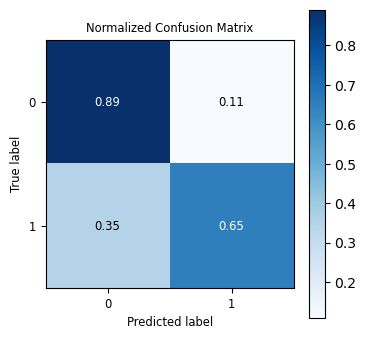

In [43]:
# affichage de la matrice de confusion normalisée
skplt.metrics.plot_confusion_matrix(y_test, y_pred, normalize=True, figsize=(4,4), 
                                    title_fontsize='small', text_fontsize='small');

In [44]:
# affichage des combinaisons possibles d'hyperparamètres et des performances moyennes du modèle associé
grid = pd.DataFrame.from_dict(gcv_svm.cv_results_).loc[:,['params','rank_test_score','mean_test_score',
                                                         'mean_fit_time','mean_score_time']]
grid.set_index('rank_test_score').sort_values(by='rank_test_score')

,params,mean_test_score,mean_fit_time,mean_score_time
rank_test_score,,,,
1,"{'gamma': 0.5, 'kernel': 'rbf'}",0.764827,697.838695,20.02064


In [45]:
# méthode d'évaluation du score sur le jeu d'entraînement par cross-validation
cv_scores_train = cross_val_score(gcv_svm, X_train_scaled, y_train, cv=3, scoring=scoring)

print('Cross-validation scores (train): {}'.format(cv_scores_train))
print('Average cross-validation score (train): {}'.format(cv_scores_train.mean()))

Cross-validation scores (train): [0.76076785 0.76730654 0.76214757]
Average cross-validation score (train): 0.7634073185362927


- **Le score de la méthode SVM pour le jeu d'entraînement est en moyenne de : 0.76**.

In [46]:
# méthode d'évaluation du score sur le jeu de test par cross-validation
cv_scores_test = cross_val_score(gcv_svm, X_test_scaled, y_test, cv=3, scoring=scoring)

print('Cross-validation scores (test): {}'.format(cv_scores_test))
print('Average cross-validation score (test): {}'.format(cv_scores_test.mean()))

Cross-validation scores (test): [0.83997443 0.84380993 0.83880247]
Average cross-validation score (test): 0.8408622771503658


- **Le score de la méthode SVM pour le jeu de test est en moyenne de : 0.84**.

In [47]:
# probabilités pour "X_test_scaled" d'appartenir à chacune des deux classes
y_probas = gcv_svm.predict_proba(X_test_scaled)

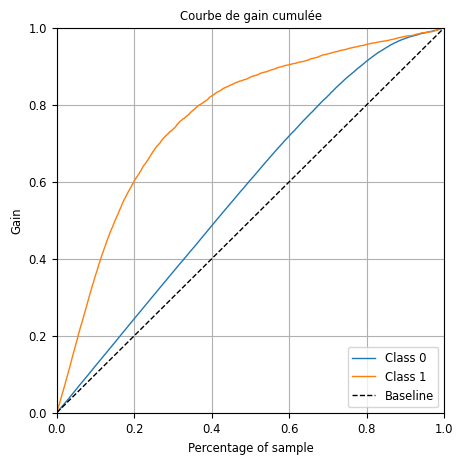

In [48]:
# affichage de la courbe de gain cumulée
ax = skplt.metrics.plot_cumulative_gain(y_test, y_probas, figsize=(5,5), title_fontsize='small', text_fontsize='small')
for l in ax.lines:
    l.set_lw(1.0)
ax.legend(loc="lower right", fontsize="small")
ax.set_title("Courbe de gain cumulée", fontsize="small");

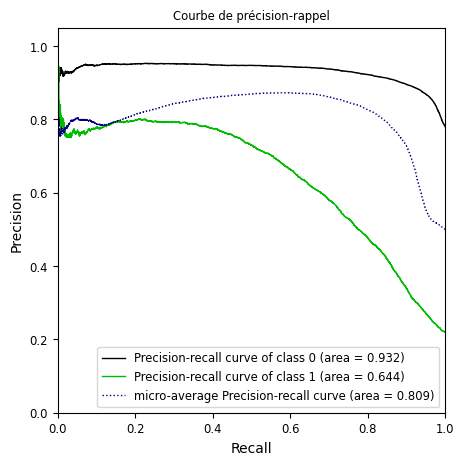

In [49]:
# affichage de la courbe de précision-rappel
ax = skplt.metrics.plot_precision_recall(y_test, y_probas, figsize=(5,5), title_fontsize='small', text_fontsize='small')
for l in ax.lines:
    l.set_lw(1.0)
ax.legend(loc="lower right", fontsize="small")
ax.set_title("Courbe de précision-rappel", fontsize="small");

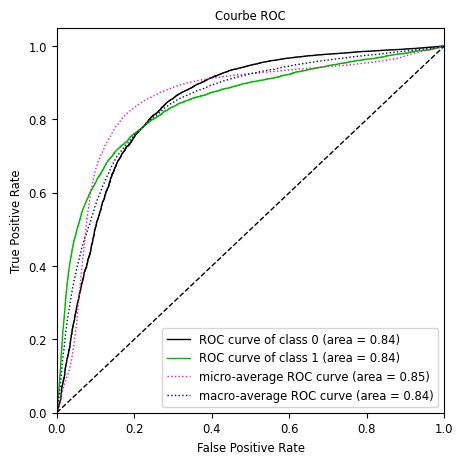

In [50]:
# affichage de la courbe ROC
ax = skplt.metrics.plot_roc(y_test, y_probas, figsize=(5,5), title_fontsize='small', text_fontsize='small')
for l in ax.lines:
    l.set_lw(1.0)
ax.legend(loc="lower right", fontsize="small")
ax.set_title("Courbe ROC", fontsize="small");

In [51]:
# sauvegarde des performances dans un fichier de sortie
pd.DataFrame([cv_scores_train.mean(), cv_scores_test.mean(), 
              f1_score(y_test, y_pred), recall_score(y_test, y_pred), precision_score(y_test, y_pred)],
             index=['cv_scores_train','cv_scores_test','f1_class_1','recall_class_1','precision_class_1'], 
             columns=['svm_' + param_ru]).to_csv('../scores/svm_'+scoring+'_'+param_ru+'.csv')

### K-plus proches voisins

In [52]:
# définition du modèle
clf_knn = neighbors.KNeighborsClassifier()

param_grid_knn = {'n_neighbors' : np.arange(20,41,1), 
                  'metric' : ['minkowski','manhattan','chebyshev']}

gcv_knn = GridSearchCV(clf_knn, param_grid_knn, scoring=scoring)

In [53]:
start_time = time.time()

# entraînement du modèle
gcv_knn.fit(X_train_scaled, y_train)

# prédiction du modèle
y_pred = gcv_knn.predict(X_test_scaled)

# détermination des meilleurs paramètres
print('Meilleurs paramètres:', gcv_knn.best_params_,"\n")

# évaluation de la performance
print('Accuracy Score: {}'.format(accuracy_score(y_test, y_pred)),'\n')

# underfitting / overfitting
print('Train Data Score: {}'.format(gcv_knn.score(X_train_scaled, y_train)))
print('Test Data Score: {}'.format(gcv_knn.score(X_test_scaled, y_test)))

# matrice de confusion
print('\n Matrice de confusion:')
print('\n', pd.crosstab(y_test, y_pred, rownames=['Réalités'], colnames=['Prédictions']))

# rapport de classification
print('\n', classification_report(y_test, y_pred))

# durée d'exécution
gaussian_time = (time.time() - start_time)
print("Running Time: %s" % datetime.timedelta(seconds=gaussian_time))

Meilleurs paramètres: {'metric': 'manhattan', 'n_neighbors': 29} 

Accuracy Score: 0.7896867675261027 

Train Data Score: 0.79500099980004
Test Data Score: 0.7896867675261027

 Matrice de confusion:

 Prédictions      0     1
Réalités                
0            17415  4547
1             1375  4821

               precision    recall  f1-score   support

           0       0.93      0.79      0.85     21962
           1       0.51      0.78      0.62      6196

    accuracy                           0.79     28158
   macro avg       0.72      0.79      0.74     28158
weighted avg       0.84      0.79      0.80     28158

Running Time: 0:20:11.527825


- la méthode des K-plus proches voisins **ne fait pas l'objet de sur-apprentissage** (score par défaut de la méthode).
- la sensibilité (taux de vrais positifs) vaut 0.78.
- la spécificité (taux de vrais négatifs) vaut 0.79.
- le F1-score concernant la classe '0' de la variable 'RainTomorrow' est bon (0.85).
- le F1-score concernant la classe '1' de la variable 'RainTomorrow' est faible (0.62).

La classe '1' est caractérisée par une précision très faible, ce qui signifie que la classe n'est quasiment pas détectée, et un rappel élevé, ce qui signifie que la classe inclut peu d'observations d'autres classes lorsqu'elle est détectée.

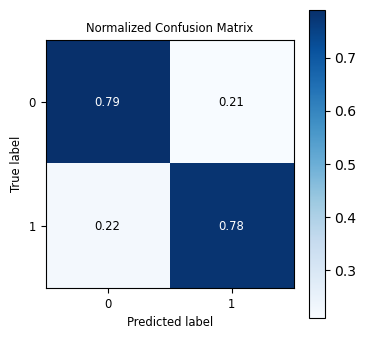

In [54]:
# affichage de la matrice de confusion normalisée
skplt.metrics.plot_confusion_matrix(y_test, y_pred, normalize=True, figsize=(4,4), 
                                    title_fontsize='small', text_fontsize='small');

In [55]:
# affichage des combinaisons possibles d'hyperparamètres et des performances moyennes du modèle associé
grid = pd.DataFrame.from_dict(gcv_knn.cv_results_).loc[:,['params','rank_test_score','mean_test_score',
                                                         'mean_fit_time','mean_score_time']]
grid.set_index('rank_test_score').sort_values(by='rank_test_score')

,params,mean_test_score,mean_fit_time,mean_score_time
rank_test_score,,,,
1,"{'metric': 'manhattan', 'n_neighbors': 29}",0.779964,0.081033,4.591742
2,"{'metric': 'minkowski', 'n_neighbors': 39}",0.779244,0.079560,3.446244
2,"{'metric': 'manhattan', 'n_neighbors': 31}",0.779244,0.079972,4.136193
4,"{'metric': 'minkowski', 'n_neighbors': 40}",0.779164,0.079930,3.372454
5,"{'metric': 'minkowski', 'n_neighbors': 31}",0.779164,0.077569,3.132141
...,...,...,...,...
59,"{'metric': 'chebyshev', 'n_neighbors': 27}",0.773665,0.081726,3.205958
60,"{'metric': 'chebyshev', 'n_neighbors': 26}",0.773625,0.081193,3.170073
61,"{'metric': 'chebyshev', 'n_neighbors': 24}",0.773525,0.082355,3.136976


In [56]:
# méthode d'évaluation du score sur le jeu d'entraînement par cross-validation
cv_scores_train = cross_val_score(gcv_knn, X_train_scaled, y_train, cv=3, scoring=scoring)

print('Cross-validation scores (train): {}'.format(cv_scores_train))
print('Average cross-validation score (train): {}'.format(cv_scores_train.mean()))

Cross-validation scores (train): [0.77804439 0.77870426 0.77594481]
Average cross-validation score (train): 0.7775644871025795


- **Le score de la méthode KNN pour le jeu d'entraînement est en moyenne de : 0.78**.

In [57]:
# méthode d'évaluation du score sur le jeu de test par cross-validation
cv_scores_test = cross_val_score(gcv_knn, X_test_scaled, y_test, cv=3, scoring=scoring)

print('Cross-validation scores (test): {}'.format(cv_scores_test))
print('Average cross-validation score (test): {}'.format(cv_scores_test.mean()))

Cross-validation scores (test): [0.84924355 0.85212018 0.8473258 ]
Average cross-validation score (test): 0.8495631792030683


- **Le score de la méthode KNN pour le jeu de test est en moyenne de : 0.85**.

In [58]:
# probabilités pour "X_test_scaled" d'appartenir à chacune des deux classes
y_probas = gcv_knn.predict_proba(X_test_scaled)

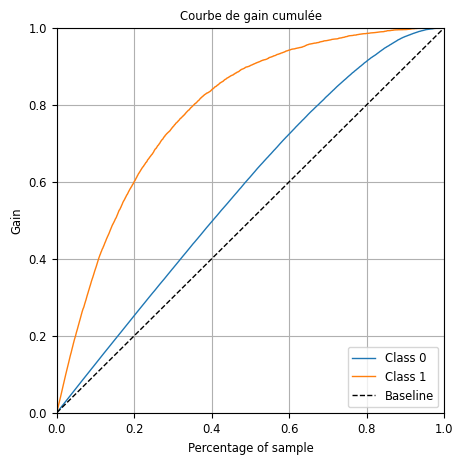

In [59]:
# affichage de la courbe de gain cumulée
ax = skplt.metrics.plot_cumulative_gain(y_test, y_probas, figsize=(5,5), title_fontsize='small', text_fontsize='small')
for l in ax.lines:
    l.set_lw(1.0)
ax.legend(loc="lower right", fontsize="small")
ax.set_title("Courbe de gain cumulée", fontsize="small");

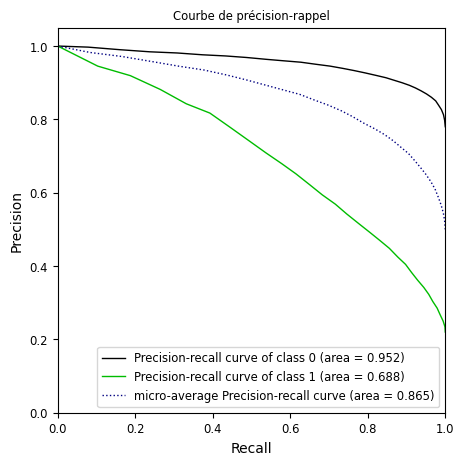

In [60]:
# affichage de la courbe de précision-rappel
ax = skplt.metrics.plot_precision_recall(y_test, y_probas, figsize=(5,5), title_fontsize='small', text_fontsize='small')
for l in ax.lines:
    l.set_lw(1.0)
ax.legend(loc="lower right", fontsize="small")
ax.set_title("Courbe de précision-rappel", fontsize="small");

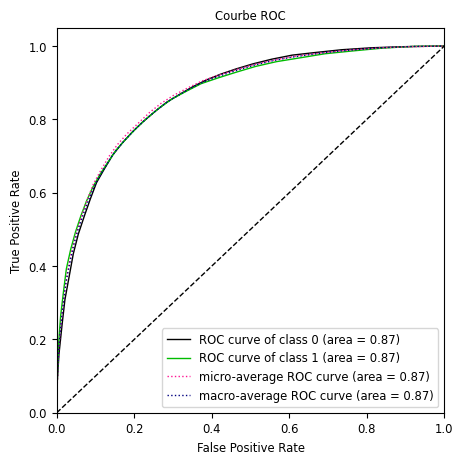

In [61]:
# affichage de la courbe ROC
ax = skplt.metrics.plot_roc(y_test, y_probas, figsize=(5,5), title_fontsize='small', text_fontsize='small')
for l in ax.lines:
    l.set_lw(1.0)
ax.legend(loc="lower right", fontsize="small")
ax.set_title("Courbe ROC", fontsize="small");

In [62]:
# scores de 3 modèles utilisant respectivement les matrices de Minkowski, Manhattan et Chebyshev 
# pour des valeurs de k allant de 1 à 40
score_minko = []
score_man = []
score_cheb = []

for k in range(1,41):
  knn = neighbors.KNeighborsClassifier(n_neighbors=k)
  knn.fit(X_train_scaled, y_train)
  score_minko.append(knn.score(X_test_scaled, y_test))

for k in range(1,41):
  knn = neighbors.KNeighborsClassifier(n_neighbors=k, metric='manhattan')
  knn.fit(X_train_scaled, y_train)
  score_man.append(knn.score(X_test_scaled, y_test))

for k in range(1,41):
  knn = neighbors.KNeighborsClassifier(n_neighbors=k, metric='chebyshev')
  knn.fit(X_train_scaled, y_train)
  score_cheb.append(knn.score(X_test_scaled, y_test))

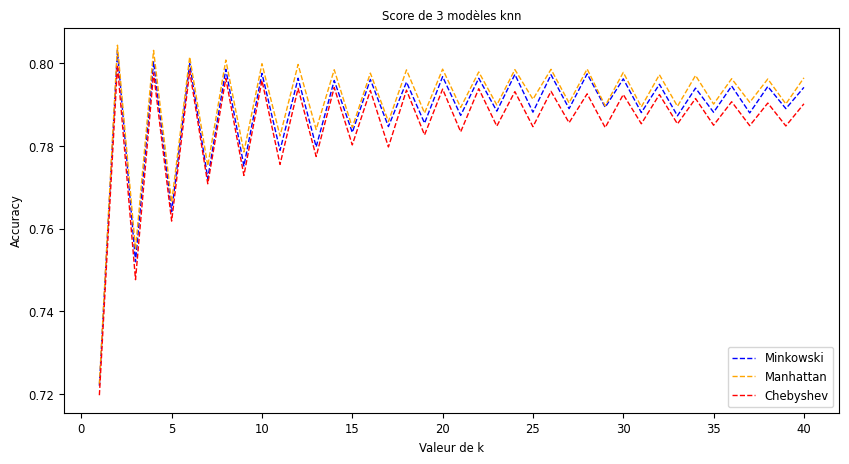

In [63]:
# affichage des scores des 3 modèles en fonction de k
plt.figure(figsize=(10,5))
plt.title("Score de 3 modèles knn", fontsize="small")
plt.plot(range(1,41), score_minko, color='blue', linestyle='dashed', lw=1, label='Minkowski')
plt.plot(range(1,41), score_man, color='orange', linestyle='dashed', lw=1, label='Manhattan')
plt.plot(range(1,41), score_cheb, color='red', linestyle='dashed', lw=1, label='Chebyshev')
plt.xlabel("Valeur de k", fontsize="small")
plt.xticks(fontsize="small")
plt.ylabel("Accuracy", fontsize="small")
plt.yticks(fontsize="small")
plt.legend(loc="lower right", fontsize="small");

Cette représentation graphique nous permet d'établir les constatations suivantes: 
- les scores des 3 modèles présentent une évolution en dent de scie alternant entre bons et moins bons résultats
- de très bons scores peuvent être obtenus avec un nombre de plus-proches voisins faible
- plus le nombre de plus-proches voisins augmente, plus l'écart entre les performances se réduit
- un nombre de plus-proches voisins élevé n'entraîne pas nécessairement une amélioration du score
- les distances de Manhattan et de Minkowski sont semblables et donnent de meilleures performances que la distance de Chebyshev

In [64]:
# sauvegarde des performances dans un fichier de sortie
pd.DataFrame([cv_scores_train.mean(), cv_scores_test.mean(), 
              f1_score(y_test, y_pred), recall_score(y_test, y_pred), precision_score(y_test, y_pred)],
             index=['cv_scores_train','cv_scores_test','f1_class_1','recall_class_1','precision_class_1'], 
             columns=['knn_' + param_ru]).to_csv('../scores/knn_'+scoring+'_'+param_ru+'.csv')

### Arbres de décision

In [65]:
# définition du modèle
clf_dt = DecisionTreeClassifier(class_weight={0:2, 1:1})

param_grid_dt = {'criterion' : ['entropy','gini'], 
                 'max_depth' : np.arange(2,6,1)}

gcv_dt = GridSearchCV(clf_dt, param_grid_dt, scoring=scoring)

In [66]:
start_time = time.time()

# entraînement du modèle
gcv_dt.fit(X_train_scaled, y_train)

# prédiction du modèle
y_pred = gcv_dt.predict(X_test_scaled)

# détermination des meilleurs paramètres
print('Meilleurs paramètres:', gcv_dt.best_params_,"\n")

# évaluation de la performance
print('Accuracy Score: {}'.format(accuracy_score(y_test, y_pred)),'\n')

# underfitting / overfitting
print('Train Data Score: {}'.format(gcv_dt.score(X_train_scaled, y_train)))
print('Test Data Score: {}'.format(gcv_dt.score(X_test_scaled, y_test)))

# matrice de confusion
print('\n Matrice de confusion:')
print('\n', pd.crosstab(y_test, y_pred, rownames=['Réalités'], colnames=['Prédictions']))

# rapport de classification
print('\n', classification_report(y_test, y_pred))

# durée d'exécution
gaussian_time = (time.time() - start_time)
print("Running Time: %s" % datetime.timedelta(seconds=gaussian_time))

Meilleurs paramètres: {'criterion': 'entropy', 'max_depth': 5} 

Accuracy Score: 0.817884792954045 

Train Data Score: 0.7471705658868226
Test Data Score: 0.817884792954045

 Matrice de confusion:

 Prédictions      0     1
Réalités                
0            19176  2786
1             2342  3854

               precision    recall  f1-score   support

           0       0.89      0.87      0.88     21962
           1       0.58      0.62      0.60      6196

    accuracy                           0.82     28158
   macro avg       0.74      0.75      0.74     28158
weighted avg       0.82      0.82      0.82     28158

Running Time: 0:00:02.308416


- la méthode des arbres de décision **ne fait pas l'objet de sur-apprentissage** (score par défaut de la méthode).
- la sensibilité (taux de vrais positifs) vaut 0.62.
- la spécificité (taux de vrais négatifs) vaut 0.87.
- le F1-score concernant la classe '0' de la variable 'RainTomorrow' est bon (0.88).
- le F1-score concernant la classe '1' de la variable 'RainTomorrow' est très faible (0.60).

La classe '1' est caractérisée par une précision faible, ce qui signifie que la classe n'est pas bien détectée, et un rappel très faible, ce qui signifie que la classe inclut beaucoup d'observations d'autres classes lorsqu'elle est détectée.

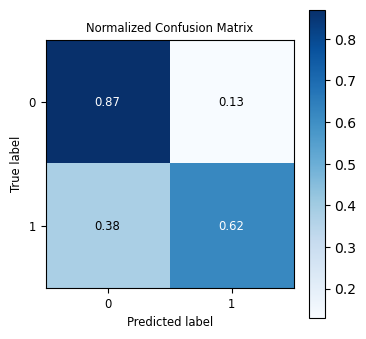

In [67]:
# affichage de la matrice de confusion normalisée
skplt.metrics.plot_confusion_matrix(y_test, y_pred, normalize=True, figsize=(4,4), 
                                    title_fontsize='small', text_fontsize='small');

In [68]:
# affichage des combinaisons possibles d'hyperparamètres et des performances moyennes du modèle associé
grid = pd.DataFrame.from_dict(gcv_dt.cv_results_).loc[:,['params','rank_test_score','mean_test_score',
                                                         'mean_fit_time','mean_score_time']]
grid.set_index('rank_test_score').sort_values(by='rank_test_score')

,params,mean_test_score,mean_fit_time,mean_score_time
rank_test_score,,,,
1,"{'criterion': 'entropy', 'max_depth': 5}",0.736393,0.072836,0.000806
2,"{'criterion': 'gini', 'max_depth': 5}",0.735493,0.070928,0.000800
3,"{'criterion': 'entropy', 'max_depth': 4}",0.731754,0.058765,0.001925
4,"{'criterion': 'gini', 'max_depth': 4}",0.726695,0.057053,0.001606
5,"{'criterion': 'entropy', 'max_depth': 2}",0.716817,0.033549,0.000809
6,"{'criterion': 'gini', 'max_depth': 2}",0.712058,0.032462,0.001114
7,"{'criterion': 'gini', 'max_depth': 3}",0.694641,0.044715,0.000800
8,"{'criterion': 'entropy', 'max_depth': 3}",0.690962,0.044556,0.003510


In [69]:
# méthode d'évaluation du score sur le jeu d'entraînement par cross-validation
cv_scores_train = cross_val_score(gcv_dt, X_train_scaled, y_train, cv=3, scoring=scoring)

print('Cross-validation scores (train): {}'.format(cv_scores_train))
print('Average cross-validation score (train): {}'.format(cv_scores_train.mean()))

Cross-validation scores (train): [0.73017397 0.73239352 0.73803239]
Average cross-validation score (train): 0.7335332933413318


- **Le score de la méthode DT pour le jeu d'entraînement est en moyenne de : 0.73**.

In [70]:
# méthode d'évaluation du score sur le jeu de test par cross-validation
cv_scores_test = cross_val_score(gcv_dt, X_test_scaled, y_test, cv=3, scoring=scoring)

print('Cross-validation scores (test): {}'.format(cv_scores_test))
print('Average cross-validation score (test): {}'.format(cv_scores_test.mean()))

Cross-validation scores (test): [0.83304922 0.83315576 0.83645856]
Average cross-validation score (test): 0.8342211804815682


- **Le score de la méthode DT pour le jeu de test est en moyenne de : 0.83**.

In [71]:
# probabilités pour "X_test_scaled" d'appartenir à chacune des deux classes
y_probas = gcv_dt.predict_proba(X_test_scaled)

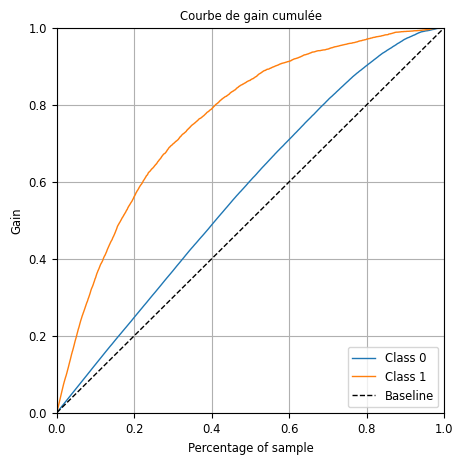

In [72]:
# affichage de la courbe de gain cumulée
ax = skplt.metrics.plot_cumulative_gain(y_test, y_probas, figsize=(5,5), title_fontsize='small', text_fontsize='small')
for l in ax.lines:
    l.set_lw(1.0)
ax.legend(loc="lower right", fontsize="small")
ax.set_title("Courbe de gain cumulée", fontsize="small");

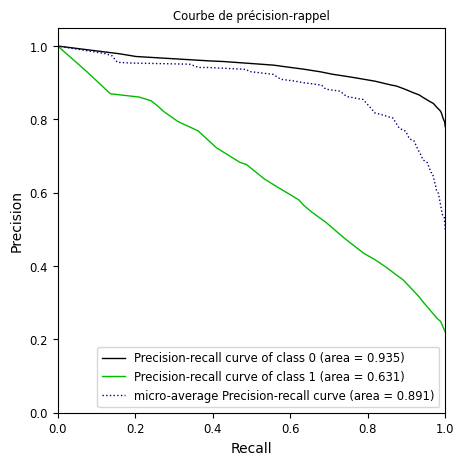

In [73]:
# affichage de la courbe de précision-rappel
ax = skplt.metrics.plot_precision_recall(y_test, y_probas, figsize=(5,5), title_fontsize='small', text_fontsize='small')
for l in ax.lines:
    l.set_lw(1.0)
ax.legend(loc="lower right", fontsize="small")
ax.set_title("Courbe de précision-rappel", fontsize="small");

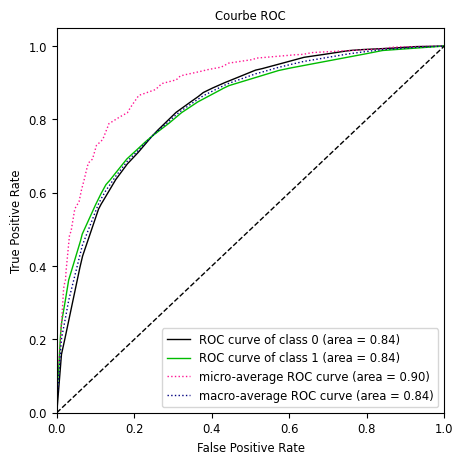

In [74]:
# affichage de la courbe ROC
ax = skplt.metrics.plot_roc(y_test, y_probas, figsize=(5,5), title_fontsize='small', text_fontsize='small')
for l in ax.lines:
    l.set_lw(1.0)
ax.legend(loc="lower right", fontsize="small")
ax.set_title("Courbe ROC", fontsize="small");

In [75]:
# importance des variables dans le jeu de données
clf_dt = gcv_dt.best_estimator_
clf_dt.fit(X_train_scaled,y_train)

feats = {}
for feature, importance in zip(df.columns, clf_dt.feature_importances_):
    feats[feature] = importance
    
importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0:'Importance'})
importances.sort_values(by='Importance', ascending=False).head(8)

,Importance
Humidity3pm,0.666812
Sunshine,0.136419
WindGustSpeed,0.070539
Pressure9am,0.064075
Rainfall,0.047571
clim_méditerranéen,0.004425
Humidity_Delta,0.003860
Temp3pm,0.003182


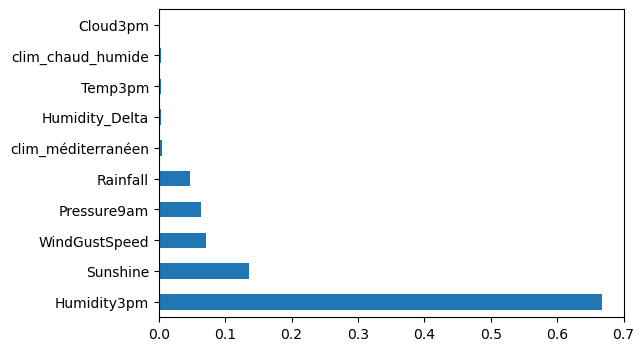

In [76]:
# affichage de l'importance des variables (MDI) dans le jeu de données
feature_imp = pd.Series(clf_dt.feature_importances_,index=data.columns)
feature_imp.nlargest(10).plot(kind='barh', figsize=(6,4));

In [77]:
# sauvegarde des performances dans un fichier de sortie
pd.DataFrame([cv_scores_train.mean(), cv_scores_test.mean(), 
              f1_score(y_test, y_pred), recall_score(y_test, y_pred), precision_score(y_test, y_pred)],
             index=['cv_scores_train','cv_scores_test','f1_class_1','recall_class_1','precision_class_1'], 
             columns=['dt_' + param_ru]).to_csv('../scores/dt_'+scoring+'_'+param_ru+'.csv')

## Résumé des performances

In [78]:
# paramètre à choisir pour afficher le résumé des résultats des performances
# summary = 'accuracy'
# summary = 'f1'
summary = 'all'

In [79]:
# concaténation des résultats de performance
if param_ru == 'rUs' or param_ru == 'cc':
    if summary == 'accuracy' or summary == 'all':
        scores_dt_accuracy_under_sample = pd.read_csv('../scores/dt_accuracy_'+param_ru+'.csv', index_col=0)
        scores_knn_accuracy_under_sample = pd.read_csv('../scores/knn_accuracy_'+param_ru+'.csv', index_col=0)
        scores_svm_accuracy_under_sample = pd.read_csv('../scores/svm_accuracy_'+param_ru+'.csv', index_col=0)
        scores_rf_accuracy_under_sample = pd.read_csv('../scores/rf_accuracy_'+param_ru+'.csv', index_col=0)
        scores_lr_accuracy_under_sample = pd.read_csv('../scores/lr_accuracy_'+param_ru+'.csv', index_col=0)
    
        df_accuracy_under_sample = pd.concat([scores_lr_accuracy_under_sample, scores_rf_accuracy_under_sample, 
                                              scores_svm_accuracy_under_sample, scores_knn_accuracy_under_sample,
                                              scores_dt_accuracy_under_sample], axis=1)

    if  summary == 'f1' or summary == 'all':
        scores_dt_f1_under_sample = pd.read_csv('../scores/dt_f1_'+param_ru+'.csv', index_col=0)
        scores_knn_f1_under_sample = pd.read_csv('../scores/knn_f1_'+param_ru+'.csv', index_col=0)
        scores_svm_f1_under_sample = pd.read_csv('../scores/svm_f1_'+param_ru+'.csv', index_col=0)
        scores_rf_f1_under_sample = pd.read_csv('../scores/rf_f1_'+param_ru+'.csv', index_col=0)
        scores_lr_f1_under_sample = pd.read_csv('../scores/lr_f1_'+param_ru+'.csv', index_col=0)
    
        df_f1_under_sample = pd.concat([scores_lr_f1_under_sample, scores_rf_f1_under_sample, scores_svm_f1_under_sample, 
                                        scores_knn_f1_under_sample, scores_dt_f1_under_sample], axis=1)
    
elif param_ru == 'rOs' or param_ru == 'smo':
    if summary == 'accuracy' or summary == 'all':
        scores_dt_accuracy_over_sample = pd.read_csv('../scores/dt_accuracy_'+param_ru+'.csv', index_col=0)
        scores_knn_accuracy_over_sample = pd.read_csv('../scores/knn_accuracy_'+param_ru+'.csv', index_col=0)
        scores_svm_accuracy_over_sample = pd.read_csv('../scores/svm_accuracy_'+param_ru+'.csv', index_col=0)
        scores_rf_accuracy_over_sample = pd.read_csv('../scores/rf_accuracy_'+param_ru+'.csv', index_col=0)
        scores_lr_accuracy_over_sample = pd.read_csv('../scores/lr_accuracy_'+param_ru+'.csv', index_col=0)
    
        df_accuracy_over_sample = pd.concat([scores_lr_accuracy_over_sample, scores_rf_accuracy_over_sample, 
                                             scores_svm_accuracy_over_sample, scores_knn_accuracy_over_sample,
                                             scores_dt_accuracy_over_sample], axis=1)

    if  summary == 'f1' or summary == 'all':
        scores_dt_f1_over_sample = pd.read_csv('../scores/dt_f1_'+param_ru+'.csv', index_col=0)
        scores_knn_f1_over_sample = pd.read_csv('../scores/knn_f1_'+param_ru+'.csv', index_col=0)
        scores_svm_f1_over_sample = pd.read_csv('../scores/svm_f1_'+param_ru+'.csv', index_col=0)
        scores_rf_f1_over_sample = pd.read_csv('../scores/rf_f1_'+param_ru+'.csv', index_col=0)
        scores_lr_f1_over_sample = pd.read_csv('../scores/lr_f1_'+param_ru+'.csv', index_col=0)
    
        df_f1_under_sample = pd.concat([scores_lr_f1_over_sample, scores_rf_f1_over_sample, scores_svm_f1_over_sample, 
                                        scores_knn_f1_over_sample, scores_dt_f1_over_sample], axis=1)    

In [80]:
# affichage du résumé des performances
if param_ru == 'rUs' or param_ru == 'cc':
    if summary == 'accuracy' or summary == 'all':
        display(df_accuracy_under_sample)
    if  summary == 'f1' or summary == 'all':
        display(df_f1_under_sample)
elif param_ru == 'rOs' or param_ru == 'smo':
    if summary == 'accuracy' or summary == 'all':
        display(df_accuracy_over_sample)
    if  summary == 'f1' or summary == 'all':
        display(df_f1_over_sample)

,lr_rUs,rf_rUs,svm_rUs,knn_rUs,dt_rUs
cv_scores_train,0.752190,0.783383,0.763407,0.777564,0.733533
cv_scores_test,0.836672,0.850273,0.840862,0.849563,0.834221
f1_class_1,0.621448,0.625198,0.634798,0.619507,0.600499
recall_class_1,0.624758,0.795675,0.651549,0.778083,0.622014
precision_class_1,0.618173,0.514883,0.618887,0.514624,0.580422


,lr_rUs,rf_rUs,svm_rUs,knn_rUs,dt_rUs
cv_scores_train,0.710912,0.784777,0.732919,0.775639,0.660338
cv_scores_test,0.470617,0.590861,0.506683,0.578711,0.470225
f1_class_1,0.622569,0.623860,0.640019,0.619475,0.563962
recall_class_1,0.625081,0.795029,0.651227,0.774693,0.513719
precision_class_1,0.620077,0.513339,0.629191,0.516074,0.625098
